<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/TPMLGymGA-Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning
## Appliqué à [Gymnasium.OpenAI](https://gymnasium.farama.org/index.html)

Voir la page d'[introduction à Gym](https://github.com/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/TPMLIntroGym.ipynb).

### Installation de gym

#### Outil AUTRE QUE COLAB (pyzo, jupyter lab, .....)

In [ ]:
#si pas deja installes 
%pip install gymnasium
%pip install gymnasium[classic-control]

#### <font color=red>Sous colab</font>
*Sous colab, l'affichage ne sera pas dynamique.. Il faudra passer soit par un rendu sous forme de plot (matplotlib), soit passer par une vidéo à enregistrer...*

***Solution pour affichage statique***<br>
*Il vous faut importer, seulement si vous utilisez colab, les packages suivants :*

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils

In [ ]:
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

---
## Charger l' environnement
Quulques importation de librairie

In [2]:
#Quelques imports
import gymnasium as gym
import numpy as np
from random import randint
import matplotlib.pyplot as plt

On utilise ici l'environnement "MountainCarContinuous-v0".  
- On le charge avec un rendu "human" si l'on travaille sur sa machine et souhaite une animation dynamique.
- On le charge avec le rendu "rgb_array" si l'on travaille sous un système tel que Colab ou ne souhaite pas d'animation.

In [3]:
#exemple pour outil autre que colab
env = gym.make('MountainCarContinuous-v0', render_mode="human") 
env.reset()
#exemple pour colab
#env = gym.make('MountainCarContinuous-v0', render_mode="rgb_array") 
#env.reset()

(array([-0.5365359,  0.       ], dtype=float32), {})

---
### Les valeurs des caractéristiques
Pour `MountainCarContinuous-v0`, vous trouverez l'explication des valeurs [ici](https://github.com/openai/gym/wiki/MountainCarContinuous-v0).

| No | Observation | Min | Max |
|:--:|:--:|:--:|:--:|
| 0 | Position | -1.2 | 0.6 |
| 1 | Velocité | -0.07 | 0.07 |

Vérification : 

In [5]:
print(env.spec)
print("nombre et type d'actions = ", env.action_space) 
print("valeurs d'actions les plus elevées = ", env.action_space.high) 
print("valeurs d'actions les plus basses = ", env.action_space.low)  
print("nombre et type d'observations = ", env.observation_space) 
print("valeurs de  observations les plus basses = ", env.observation_space.low) 
print("valeurs de observations les plus elevées = ", env.observation_space.high) 

EnvSpec(id='MountainCarContinuous-v0', entry_point='gymnasium.envs.classic_control.continuous_mountain_car:Continuous_MountainCarEnv', reward_threshold=90.0, nondeterministic=False, max_episode_steps=999, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'render_mode': 'human'}, namespace=None, name='MountainCarContinuous', version=0, additional_wrappers=(), vector_entry_point=None)
nombre et type d'actions =  Box(-1.0, 1.0, (1,), float32)
valeurs d'actions les plus elevées =  [1.]
valeurs d'actions les plus basses =  [-1.]
nombre et type d'observations =  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
valeurs de  observations les plus basses =  [-1.2  -0.07]
valeurs de observations les plus elevées =  [0.6  0.07]


### (Re)Initialiser l'environnement
`env.reset()` initialise les variables d'environnement. L'exécution est obligatoire après avoir chargé l'environnement. Ici ce sont la position de départ et la vitesse.
Pour avoir un environnement non déterministe, par défaut `env.reset()` retourne une position x aléatoire entre -0.4 et -0.6 et une vitesse initiale nulle : 

In [8]:
env.reset()

(array([-0.5892358,  0.       ], dtype=float32), {})

Mais ici nous souhaitons partir du même point (-0.5) à vitesse nulle à chaque test de séquence d'actions. Avant chaque évaluation de séquence d'actions, ***on n'utilisera pas*** `env.reset()` par la suite et on écrira donc : 

In [9]:
env.reset(seed=123, options={"x_init": 0., "y_init": 0.})

(array([-0.46352962,  0.        ], dtype=float32), {})

---
### Les actions
- Dans `MountainCarContinuous-v0` : [-1.0] fait reculer le véhicule d'une force 1, [0] le met au point mort, [1.0] le fait avancer d'une force 1

- ***Exécuter une action :***
  - *exécution* : `observation, reward,done,info = env.step(action)`
    - `observation`: ici la position du mobile et sa vitesse ([x, v])
    - `reward`: utilité de l'état (récompense)
    - `done` : booléen (True si but atteint)
    - `info` : éventuelle information retournée par l'outil

In [12]:
env.reset(seed=123, options={"x_init": 0., "y_init": 0.})
action = 1
observation, reward,done,stopped,info = env.step([float(action)])
print("x=", observation[0])
print("v=", observation[1])
observation, reward,done,stopped, info = env.step([float(action)])
print("x=", observation[0])
print("v=", observation[1])

x= -0.4624777
v= 0.0010519158
x= -0.46038163
v= 0.0020960723


---
### La récompense (reward)
Le *reward* dépend l'environnement d'exécution.. Dans `MountainCarContinuous-v0`, il est de `100(si le but est atteint)-le nombre d'actions au carré` !!
Selon la méthode IA choisie, il peut être plus intéressant de définir sa popre fonction récompense 
(par exemple, on peut favoriser les séquences qui mène le plus loin possible..)


---

# Test d'algorithme génétique
## Test de programme évolutionnaire pour atteindre l'objectif
- Utiliser l'environnement `MountainCarContinuous-v0`, car il est plus rapide 
- Programmez (en python) un algo génétique avec initialement les éléments suivants : 
  - sequence : tableau de valeurs entières -1, 0 ou 1.
    - *(on pourrait prendre des valeurs réelles mais ici on se contentera d'entiers pour commencer)*
  - 1 point de croisement (au centre)
    - *(pour commencer, on pourrait proposer 2 points de croisement (au 1/3, et 2/3))*
  - taille sequence : taille_seq = 80
  - taille population initiale : taille_pop = 500
  - taux de gènes mutants dans une séquence : taux_mut_seq = 0.1
  - taux de séquences mutantes dans la population : taux_mut_pop = 0.2
  - nombre max de cycles de reproductions : nb_cycles = 3000


- Pour tester une séquence, il suffit de balayer le tableau et de lancer l'action correspondante..(en la transformant en un tableau de réel (1 -> [1.0])
- Les 4 meilleures séquences (11,22,33,44) se reproduisent entre elles, donnant donc 12 fils : 12, 13, 14, 21, 23, 24, 31, 32, 34, 41, 42, 43.
- Idéalement, un filtre doit permettre de supprimer les séquences identiques qui pourraient venir des croisements et des mutations.

- Tester votre algo sur le nb de générations et afficher le rendu toutes les 100 générations et bien sûr le rendu de la meilleure séquence finale.
  - (uniquement la position finale *colab*)
  - (sous forme d'animation sous autre outil)


- ***NB:*** 
  - Au plus simple il est possible d'utiliser une population (liste) de couples [sequence, utilite] où l'utilité serait la distance en x.

In [7]:
#exemple :  
env.reset(seed=123, options={"x_init": 0., "y_init": 0.})
tab = np.random.randint(-1, 2, 10) 
triplet = [tab, False, 0]
print(triplet)
for a in triplet[0]:
    obs, reward, done, stopped, info = env.step([float(a)])
# en mode "human" l'animation s'effectue à chaque step
print("arrive en x=", round(obs[0],2), ", fini=", done)
triplet[1] = obs[0]
triplet[2] = done
print("couple [actions, arrivee] = ", triplet)

[array([ 1,  1,  1,  1, -1,  0, -1,  1, -1, -1]), False, 0]
arrive en x= -0.45 , fini= False
couple [actions, arrivee] =  [array([ 1,  1,  1,  1, -1,  0, -1,  1, -1, -1]), -0.4546837, False]


### Bonus : 
- Adapter la récompense pour favoriser les séquences qui atteignent le but en un minimum d'actions utiles (0 étant considéré comme une action inutile)

---
## Exemple de solution

Définissons des "constantes" : taille de la population, nb de cycles de vie, taille d'une séquence, taux de séquence mutante et taux de mutation dans une séquence :

In [12]:
TAILLE_POP = 500
NB_CYCLES = 3000
TAILLE_SEQ = 70
TAUX_MUT_SEQ = 0.05
TAUX_MUT_POP = 0.1

### Séquence
Tout d'abord, en algo génétique, il faut définir ce qu'est une *séquence*..
  - Ici une *séquence* est une suite d'action définie par un tableau de valeurs entières -1, 0 ou 1.
  - -1 correspond à une marche arrière à 100%, 0 au point mort et 1 à une marche avant à 100%

#### Nettoyage de séquence
Pour plus de réalisme, on va éviter les alternances de -1 et 1... Passer d'une marche avant à une marche arrière (ou inversement) obligera à passer par un point mort (0)

In [13]:
def clean_seq(seq, taille=80):
    """modifie les valeurs de sorte de ne pas avoir les valeurs -1 et 1 consécutives
    dans la séquence de taille donné (obligation de passer par une étape 'point mort'
     quand entre marche arriere et marche avant"""
    previous = seq[0]
    for i in range(1, taille):
        if (previous == -1) and (seq[i] == 1): seq[i] = 0
        if (previous == 1) and (seq[i] == -1): seq[i] = 0
        previous = seq[i]

#### Création d'une population
Posséder plusieurs fois la même séquence dans la poopulation n'est pas intéressant ici.. 
La fonction `create_pop` crée une liste contenant un certain nombre de séquences différentes, leurs récompenses (0 initialement) et le fait qu'elles aient atteint leur but ou non (Faux initialement)

In [79]:
def create_pop(taille=80, nb=500)->list:
    """crée et retourne une population de nb séquences d'une taille donnée.
    la population ne comporte pas d'éléments ayant la même séquence. 
    Un elt de la population est un triplet [sequence, utilite, succes]"""
    tabs:np.array = np.empty((nb, taille), int)
    pop:list = []
    i:int = 0
    while i<nb:
        sequence = np.random.randint(-1, 2, taille)
        clean_seq(sequence, taille)
        exist = False
        j = 0
        while (j < i) and not exist:
            exist = np.array_equal(sequence, tabs[j])
            j += 1
        if not exist: 
            tabs[i] = sequence
            i+=1
    for sequence in tabs:
        pop.append([sequence, 0.0, False])
    return pop

In [80]:
create_pop(10, 5)

[[array([0, 1, 0, 0, 1, 1, 0, 1, 0, 0]), 0.0, False],
 [array([ 0,  0, -1, -1,  0,  1,  0, -1, -1,  0]), 0.0, False],
 [array([ 0,  1,  0, -1, -1,  0, -1, -1,  0,  0]), 0.0, False],
 [array([ 1,  0, -1,  0, -1,  0, -1,  0,  0, -1]), 0.0, False],
 [array([-1, -1,  0,  1,  1,  1,  0,  0,  1,  0]), 0.0, False]]

#### Ajout d'un élément
La reproduction de séquences en génère de nouvelles, qui se trouvent parfois déjà dans la population.

La fonction suivante ajoute un triplet uniquement si sa séquence elle n'est pas déjà présente.

In [16]:
def insere_triplet(seq, pop):
    """insère une séquence dans la population si elle n'est pas déjà présente"""
    exist = False
    j = 0
    n = len(pop)
    while (j < n) and not exist:
        exist = np.array_equal(seq[0], pop[j][0])
        j += 1
    if not exist: pop.append(seq)


#### Evaluation d'une séquence
Effectuer une action dans l'environnement `MountainCarContinuous-v0` fournit 4 sorties : 
  - l'observation (position x, vitesse v)
  - récompense (utilité)
  - atteinte de l'objectif
  - information éventuelle
Ici, nous définissons notre propre fonction de récompense/d'utilité : elle est basée sur la position x (objectif x> 0.45) et sur une vitesse minimale arrivée à ce point..
L'intérêt étant d'arriver au point demandé (le drapeau) sans vitesse excessive..

A la fin de la série d'action, nous mesurons donc la position $x \in [-1.2, 0.6]$, la vitesse $v \in [-0.07 , 0.07]$, donnons une valeur de récompense sous la forme $u_{seq} = f(\frac{x}{0.6} * (1-\frac{v}{0.07}))$, où $f$ est une fonction sigmoïde calibrant la sortie entre 0 et 1, et nous validons une séquence dont l'utilité est $> 0.8$ où le $x$ final est $\geq 0.45$.

In [17]:
from math import exp
###petite fonction sigmoide
sigmoid = lambda x: 1 / (1 + exp(5 - 10*x))

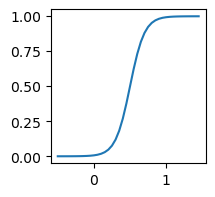

In [18]:
#petit test de la sigmoid
xs = np.arange(-0.5, 1.5, .05)
ys = [sigmoid(x) for x in xs]
fig = plt.figure(1, figsize=(2, 2))
plt.plot(xs, ys)

In [37]:
def reset(env):
    """reinitialise la position et la vitesse de la voiture"""
    env.reset(seed=123, options={"x_init": 0., "y_init": 0.})

In [54]:
def eval_seq(env, trio):
    """evaluer une sequence composee d'une liste d'actions (trio[0]),
    calcule et place l'utilite dans trio[1]
    et le fait d'etre arrive à l'objectif dans trio[2]"""
    reset(env)
    for a in trio[0]:
        obs, _, _, _, _ = env.step([float(a)])
    v = (1-abs(obs[1]/0.07))
    trio[1] = (sigmoid(obs[0]/0.6)) * (sigmoid(v))
    trio[2] = (trio[1] > 0.8) and (obs[0] > 0.45)
    return trio[2]


---
### Population
A la création de la population, il est nécessaire d'évaluer toutes les séquences.

In [39]:
def eval_pop(env, pop):
    """lance l'evaluation de chaque element de la population. s'arrete si une sequence rencontre un succes"""
    done: bool = False
    for trio in pop:
        done = eval_seq(env, trio)
        if done: break
    return done

#### Tri de la population
Les séquences doivent être triées selon leurs utilités décroissantes. 
On utilise ici la méthode de tri de Python, en spécifiant le comparateur utilisé.

In [23]:
import functools

##comparateur pour deux séquences sur base de leurs utilites
### comp(seqA, seqB)
### retourne > 0 si seqA[1] < seqB[1] (seqA sera place apres seqB)
### retourne < 0 si seqA[1] > seqB[1] (seqA sera place avant seqB)
### retourne 0  si seqA[1] = seqB[1]
comp = lambda seqA, seqB: int(round(seqB[1]*10000-seqA[1]*10000))


In [24]:
def sort_pop(pop):
    """retourne la liste de sequences triees"""
    return sorted(pop, key=functools.cmp_to_key(comp))

#### Croisement
Le croisement de 2 séquences donne deux séquences filles, composées de la combinaison des moitiées de leurs parentes.
Ces nouvelles séquences doivent être nettoyées, évaluées avant d'être éventuellement ajoutées à la population si des sosies ne sont pas déjà présents.


In [56]:
def croisement(env, seqA, seqB):
    """retourne les 2 croisements des séquences seqA et seqB,
    et le fait qu'un des croisement ait atteint l'objectif"""
    done: bool = False
    fils1 = np.concatenate((seqA[0][0:TAILLE_SEQ//2], seqB[0][TAILLE_SEQ//2:]))
    clean_seq(fils1, TAILLE_SEQ)
    couple1 = [fils1, 0., False]
    done = eval_seq(env, couple1)
    fils2 = np.concatenate((seqB[0][0:TAILLE_SEQ//2], seqA[0][TAILLE_SEQ//2:]))
    clean_seq(fils2, TAILLE_SEQ)
    couple2 = [fils2, 0., False]
    done = done or eval_seq(env, couple2)
    return couple1, couple2, done

Il est plus intéressant parfois d'effectuer des croisments entre les n premiers de la liste.

In [44]:
def croisements(env, pop, n=2):
    """lance le croisement parmis les n premiers membres de la population pop
    retourne si un des croisement a atteint l'objectif"""
    done: bool = False
    for i in range(0, n-1):
        for j in range(i+1, n):
            fils1, fils2, ok = croisement(env, pop[i], pop[j])
            done = done or ok
            insere_triplet(fils1, pop)
            insere_triplet(fils2, pop)
    return done

#### Mutation
La mutation est l'élément essentiel pour qu'un algo génétique ne tombe pas dans un minimal/maxima local.
La mutation est souvent guidée (des gènes sont désignés comme étant potentiellement mutant), mais ici la sélection sera aléatoire.
Toutefois, le résultat de la mutation d'une séquence devra être "nettoyé"...


In [58]:
def mut_seq(env, seq, nb):
    """effectue la mutation de nb elements de la sequence
    réévalue la sequence et retourne si l'objectif a été atteint"""
    for _ in range(nb):
        no = randint(0, TAILLE_SEQ-1)
        seq[0][no] = randint(-1, 1)
    clean_seq(seq[0], TAILLE_SEQ)
    return eval_seq(env, seq)

In [59]:
def mut_pop(env, pop, nb_seq, nb_genes):
    """effectue la mutation de nb elements de la population
    et retourne si l'objectif a été atteint"""
    done: bool = False
    for _ in range(nb_seq):
        no = randint(1, TAILLE_POP-1)
        done = mut_seq(env, pop[no], nb_genes)
    return done

---
### Vie
Donnons un peu de vie à cette population.
Tout d'abord une fonction qui lance l'animation de l'environnement `MountainCarContinuous-v0` pour chaque action spécifiée (ne fonctionne pas sous collab)


In [61]:
def affiche_actions(actions):
    """affiche l'animation résultant de la réalisation des actions
    actions = tableau de valeurs entre -1, 0 et 1"""
    #si on n'est pas sous collab et souhaite une animation, laisser la ligne suivante
    env = gym.make('MountainCarContinuous-v0', render_mode="human")
    reset(env)
    obs = None
    for a in actions:
        obs, _, _, _, _ = env.step([float(a)])
    # et sous collab ajouter ceci pour dessiner l'etat a la fin des actions (hors de la boucle for)
    #rendu = env.render(mode='rgb_array')
    #plt.imshow(rendu)
    print(f' arrive en {(100*obs[0]):.2f} avec une vitesse de {(obs[1]*1000):.2f}.')
    #si on est passé en mode human au début de la fonction, repasser en rgb_array
    env = gym.make('MountainCarContinuous-v0', render_mode="rgb_array")


Maintenant, assemblons les codes précédents pour : 
  - créer une population
  - répéter un certain temps, ou tant qu'une séquence n'a pas atteint lobjectif
    - croisement
    - mutation
  - de plus ici, nous souhaitons afficher l'évolution des utilités des 5 meilleures séquences..


In [52]:

def vie():
    """ cree une population, et lance pour au moins NB_CYCLES un cycle croisement,
    mutation et tri.
    Affiche la meilleure solution tous les 100 cycles
    Et trace au final l'évolution de la valuation des 5 meilleurs sequences
    retourne la population triee et eventuellement le no de la meilleure sequence"""
    env = gym.make('MountainCarContinuous-v0', render_mode="rgb_array")
    reset(env)
    pop = create_pop(TAILLE_SEQ, TAILLE_POP)
    done = eval_pop(env, pop)
    print("avant la boucle")
    nb_seq = int(TAILLE_POP * TAUX_MUT_POP)
    nb_genes = int(TAILLE_SEQ * TAUX_MUT_SEQ)
    i = 0
    ## on veut tracer l'evolution des utilités des 5 meilleures
    courbes = [[], [], [], [], []]
    if not done:
        for i in range(1, NB_CYCLES):
            done = croisements(env, pop, 4)
            if done: break
            done = done or mut_pop(env, pop, nb_seq, nb_genes)
            pop = sort_pop(pop)
            if done: break
            for j in range(0, 5): courbes[j].append(pop[j][1])
            if i%100 == 0:
                print("les 5 meilleures valeurs = ", end="")
                for j in range(0, 5): print(f'{pop[j][1]:.3f}', end=", ")
                print()
                actions = pop[0][0]
                print("la 1ere sequence ", end="")
                affiche_actions(actions)
    print("fin au bout de ", i, " itérations...")
    ##retrouver la séquence qui a obtenu le succes
    i = 0
    if done:
        done = False
        while not done and (i < len(pop)):
            done = pop[i][2]
            if not done: i = i + 1
    actions = pop[i][0]
    affiche_actions(actions)
    print(actions)
    ## afficher l'évolution des utilités des 5 meilleures séquences
    plt.figure(figsize=(9, 9))
    xs = range(0, len(courbes[0]))
    for i in range(0, 5):
        plt.plot(xs, courbes[i])
    plt.show()
    return pop, i

Lancer l'algorithme : 

avant la boucle
les 5 meilleures valeurs = 0.155, 0.155, 0.144, 0.144, 0.119, 
la 1ere sequence  arrive en 20.97 avec une vitesse de 22.64.
les 5 meilleures valeurs = 0.297, 0.279, 0.190, 0.183, 0.171, 
la 1ere sequence  arrive en 26.11 avec une vitesse de 21.95.
les 5 meilleures valeurs = 0.429, 0.423, 0.384, 0.364, 0.361, 
la 1ere sequence  arrive en 29.80 avec une vitesse de 21.52.
les 5 meilleures valeurs = 0.570, 0.567, 0.560, 0.521, 0.519, 
la 1ere sequence  arrive en 35.30 avec une vitesse de 25.05.
les 5 meilleures valeurs = 0.660, 0.632, 0.613, 0.609, 0.595, 
la 1ere sequence  arrive en 36.60 avec une vitesse de 21.04.
les 5 meilleures valeurs = 0.704, 0.697, 0.666, 0.662, 0.648, 
la 1ere sequence  arrive en 40.22 avec une vitesse de 23.81.
les 5 meilleures valeurs = 0.754, 0.751, 0.751, 0.749, 0.748, 
la 1ere sequence  arrive en 40.94 avec une vitesse de 21.31.
les 5 meilleures valeurs = 0.790, 0.785, 0.785, 0.784, 0.778, 
la 1ere sequence  arrive en 41.82 avec une vitesse de

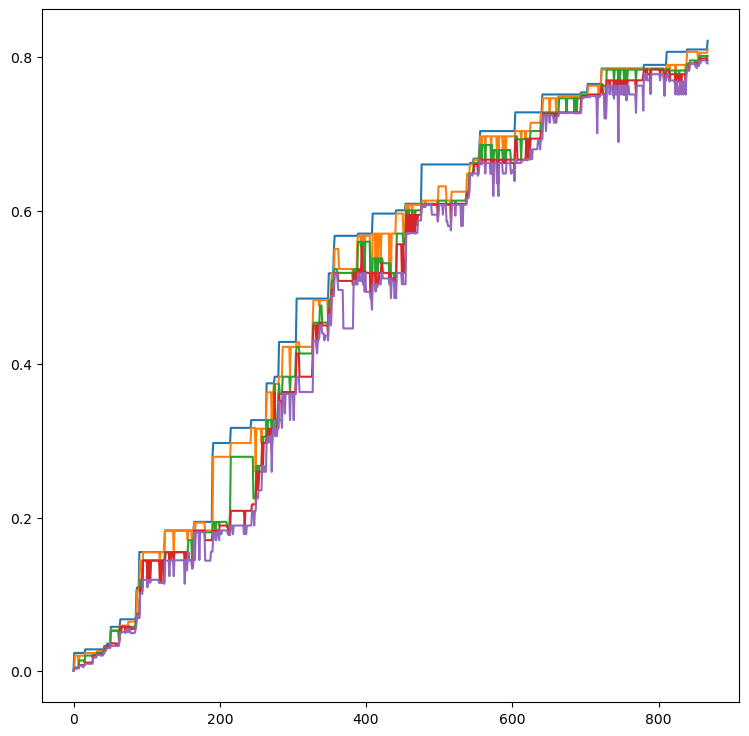

In [62]:
##lancement du cycle de vie
p, val = vie()

In [24]:
# pour clore l'environnement
#env.close()

Les sauts sont des sauts d'évolution dûs aux mutations.